# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [ ]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


При выводе первых пяти строк таблицы видны пропуски (значения NaN) в нескольких столбцах.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Вывод общей информции показывает, что:**

1. есть пропуски в 14 столбцах. Нужно провести заполнение пропусков там, где это возможно
    
2. в столбце first_day_exposition указаны даты, но тип данных object, хотя должен быть datetime64. Нужно исправить.
    
3. в столбце floors_total указано количество этажей, но тип данных float64. Этажей не может быть не целое число.
    Нужно исправить на int64.
    
4. в столбце is_apartment указана принадлежность к апартаментам, но тип данных object. Нужно исправить на bool.
    
5. в столбцах 13, 15-21 тип данных float64, но значения должны быть целыми. Это не критично, но можно исправить тип данных на int64

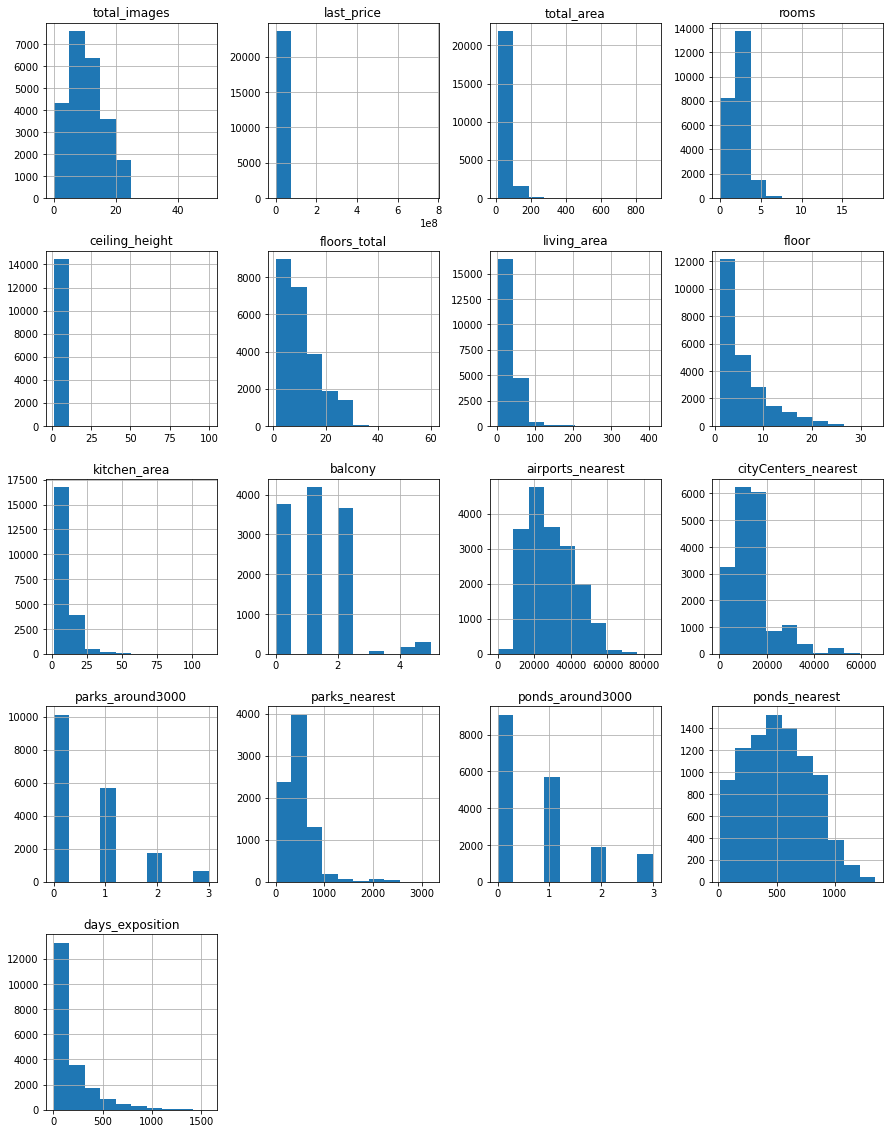

In [ ]:
data.hist(figsize=(15, 20))
plt.show()

### Выполните предобработку данных

#### Поиск и заполнение пропущеннных значений

In [ ]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Пропуски, допущенные продавцом при заполнении объявления:**

**ceiling_height**       9195 - в данном столбце много пропусков и данный параметр потребуется для дальнейшего                                           исследования, поэтому пропуски в нем будут заменены на **медианное значение**.

**floors_total**           86 - логичную замену предположить невозможно, поэтому **пропуски оставим незаполенными**.

**living_area**          1903 - для сохранения данных будет произведена замена на **значение общей площади умноженное на                                 медианное значение отношения двух площадей**.

**is_apartment**        20924 - нужно посмотреть сколько значений True и False имеет данный столбец, после этого                                         понять, можно ли заполнить пропуски логичными значениями. Вероятоно будет **произведена                                   замена на значение False**

**kitchen_area**         2278 - для сохранения данных будет произведена замена на **значение разности общей и жилой                                       площади данной квартиры, умноженное на медианное значение отношения площади кухни к                                       разности общей и жилой площади**

**balcony**             11519 - выполнить **заполнение всех пропусков на **значение 0**, т.к. вероятнее всего балконов в                                 этих квартирах нет.

**Пропуски, появившиеся из-за того, что продавец не указал адрес квартиры или техническая ошибка:**

**locality_name**          49 - не указан адрес объекта. **Замену произвести невозможно**

**airports_nearest**     5542 - техническая ошибка. **Логичное заполнение предположить невозможно**.

**cityCenters_nearest**  5519 - техническая ошибка. **Логичное заполнение предположить невозможно**.

**parks_around3000**     5518 - техническая ошибка. **Логичное заполнение предположить невозможно**.

**parks_nearest**       15620 - сумма пропусков здесь состоит из пропусков предыдущего пункта (5518) и количества                                         объектов, у которых в предыщущем пункте стоит значение 0 (10106 шт.), т.е. парков в                                       радиусе 3 км нет.)

**ponds_around3000**    5518 - техническая ошибка. **Логичное заполнение предположить невозможно**.

**ponds_nearest**      14589 - сумма пропусков здесь состоит из пропусков предыдущего пункта (5518) и количества                                        объектов, у которых в предыщущем пункте стоит значение 0 (9071 шт.), т.е. водоемов в                                      радиусе 3 км нет.)


**days_exposition**     3181 - **возможно объявления ещё не сняты**

In [ ]:
print(data[data['parks_around3000'] == 0]['parks_around3000'].count()) # код для проверки количества нулевых значений в столбце parks_around3000
print(data[data['ponds_around3000'] == 0]['ponds_around3000'].count()) # код для проверки количества нулевых значений в столбце ponds_around3000

10106
9071


**Заполнение пропусков в столбце ceiling_height на медианное значение**

In [ ]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

**Заполнение пропусков в столбце living_area на значение процентной величины от общей площади**

Для заполнения данного столбца будет произведен расчет коэффициента корреляции между жилой и общей площадью, затем найдено медианное значение отношения жилой и общей площади, и далее произведено заполнение пропусков на значение общей площади умноженное на медианное значение отношения двух площадей.

In [ ]:
data['living_area'].corr(data['total_area']) # расчет коэффициента корреляции между living_area и total_area

0.9395373338721493

In [ ]:
# расчет медианного значения отношения между living_area и total_area
living_per_total_area = (data['living_area'] / data['total_area']).median()
living_per_total_area

0.5678598992678503

In [ ]:
# заполнение пропусков на значение разности общей и жилой площади данной квартиры, умноженное на медианное значение отношения площади кухни к разности общей и жилой площади
data['living_area'] = data['living_area'].fillna(data["total_area"] * living_per_total_area).round(0)

**Заполнение пропусков в столбце kitchen_area на значение процентной величины отношения площади кухни к разности общей площади и жилой площади**

Весь расчет будет выполнен по аналогии с предыщущим

In [ ]:
data['kitchen_area'].corr(data['total_area'] - data['living_area']) # расчет коэффициента корреляции

0.7299425768351462

In [ ]:
# расчет медианного значения отношения между kitchen_area и разностью total_area и living_area
kitchen_area_NaN = (data['kitchen_area'] / (data['total_area'] - data['living_area'])).median()
kitchen_area_NaN

0.4117647058823529

In [ ]:
# заполнение пропусков на значение общей площади умноженное на медианное значение отношения двух площадей и округление значения
data['kitchen_area'] = data['kitchen_area'].fillna((data['total_area'] - data['living_area']) * kitchen_area_NaN).round(0)

**Заполнение пропусков в столбце is_apartment на значение False**

In [ ]:
display(data[data['is_apartment'] == True]['is_apartment'].count())
display(data[data['is_apartment'] == False]['is_apartment'].count())

50

2725

В столбце is_apartment 20924 пропусков из 23699 значений. 50 значений True, 2725 значений False.

В следующем коде будет выполнена замена всех пропусков в данном столбце на значение False.

Есть вероятность, что продавцы специально не указали в объявлении, что это апартаменты, т.к. они имеют ряд "недостатков".

Правильно ли делать замену?


In [ ]:
data['is_apartment'] = data['is_apartment'].fillna('False')

**Заполнение пропусков в столбце balcony на значение 0**

In [ ]:
data['balcony'] = data['balcony'].fillna('0').astype('int32')

**Заполнение пропусков в столбцах airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000**

In [ ]:
# проверка наличия пропусков по данным столбцам в Санкт-Петербурге
display(data.loc[(data['airports_nearest'].isna()) & data['locality_name'] == 'Санкт-Петербург'])
display(data.loc[(data['cityCenters_nearest'].isna()) & data['locality_name'] == 'Санкт-Петербург'])
display(data.loc[(data['parks_around3000'].isna()) & data['locality_name'] == 'Санкт-Петербург'])
display(data.loc[(data['ponds_around3000'].isna()) & data['locality_name'] == 'Санкт-Петербург'])

# проверка наличия пропусков по данным столбцам в Пушкине
display(data.loc[(data['airports_nearest'].isna()) & data['locality_name'] == 'Пушкин'])
display(data.loc[(data['cityCenters_nearest'].isna()) & data['locality_name'] == 'Пушкин'])
display(data.loc[(data['parks_around3000'].isna()) & data['locality_name'] == 'Пушкин'])
display(data.loc[(data['ponds_around3000'].isna()) & data['locality_name'] == 'Пушкин'])

# проверка наличия пропусков по данным столбцам в посёлке Мурино
display(data.loc[(data['airports_nearest'].isna()) & data['locality_name'] == 'посёлок Мурино'])
display(data.loc[(data['cityCenters_nearest'].isna()) & data['locality_name'] == 'посёлок Мурино'])
display(data.loc[(data['parks_around3000'].isna()) & data['locality_name'] == 'посёлок Мурино'])
display(data.loc[(data['ponds_around3000'].isna()) & data['locality_name'] == 'посёлок Мурино'])

# проверка наличия пропусков по данным столбцам в посёлке Шушары
display(data.loc[(data['airports_nearest'].isna()) & data['locality_name'] == 'посёлок Шушары'])
display(data.loc[(data['cityCenters_nearest'].isna()) & data['locality_name'] == 'посёлок Шушары'])
display(data.loc[(data['parks_around3000'].isna()) & data['locality_name'] == 'посёлок Шушары'])
display(data.loc[(data['ponds_around3000'].isna()) & data['locality_name'] == 'посёлок Шушары'])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Данная проверка позволяет сделать вывод, что пропуски по столбцам 15-20 присутствуют только в маленьких населенных пунктах, таких как деревни, поселки и т.д. Кроме того, пропуски присутствуют во всех столбцах (15-20), что говорит о том, что это **техническая ошибка**.

В таких населенных пунктах не имеет значение отдаленность от центра, количество парков и прудов, но может иметь значение отдаленность от аэропорта.

О данной ошибке можно сообщить разработчикам сервиса.

**Для нашего исследования можно отсавить пропуски незаполненными или заменить все значения на 0.**

**Заменим значения на 0**

In [ ]:
data['airports_nearest'] = data['airports_nearest'].fillna('0')

data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna('0')

data['parks_around3000'] = data['parks_around3000'].fillna('0')

data['parks_nearest'] = data['parks_nearest'].fillna('0')

data['ponds_around3000'] = data['ponds_around3000'].fillna('0')

data['ponds_nearest'] = data['ponds_nearest'].fillna('0')

In [ ]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total              86
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name             49
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3181
dtype: int64

Пропуски остались в 3 столбцах, где логическая замена невозможна

#### Изменение типов данных

**Перевод дат в столбце first_day_exposition в стандартный формат**

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

**Перевод формата данных в столбцах 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'ponds_around3000', 'parks_nearest', 'ponds_nearest' в правильный формат**

In [ ]:
for i in data[['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'ponds_around3000', 'parks_nearest', 'ponds_nearest']]:
    data[i] = data[i].astype('int')

In [ ]:
data['is_apartment'] = data['is_apartment'].astype('bool')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

При преобразовании типа данных столбца floors_total появляется ошибка: Cannot convert non-finite values (NA or inf) to integer. Но т.к. данное преобразование не критично, оставляем тип без изменений

#### Устранение дубликатов

**Поиск явных дубликатов**

In [ ]:
data.duplicated().sum()

0

**Поиск и устранение неявных дубликатов**

In [ ]:
data['locality_name'].value_counts()

Санкт-Петербург        15721
посёлок Мурино           522
посёлок Шушары           440
Всеволожск               398
Пушкин                   369
                       ...  
село Никольское            1
поселок Гладкое            1
деревня Иссад              1
деревня Пустынка           1
поселок Дружноселье        1
Name: locality_name, Length: 364, dtype: int64

In [ ]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace('поселок городского типа', 'поселок', regex=True)
)

In [ ]:
data['locality_name'].value_counts().count()

329

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
# вывод полного списка значений столбца locality_name c группировкой по уникальным значениям и сортировкой по названиям для "ручного" просмотра дубликатов
data['locality_name'].value_counts().sort_index()

Бокситогорск                                                  16
Волосово                                                      36
Волхов                                                       111
Всеволожск                                                   398
Выборг                                                       237
Высоцк                                                         4
Гатчина                                                      307
Зеленогорск                                                   24
Ивангород                                                     28
Каменногорск                                                  13
Кингисепп                                                    104
Кириши                                                       125
Кировск                                                       84
Колпино                                                      338
Коммунар                                                      89
Красное Село             

In [ ]:
# удаление из названий населенных пунктов "лишних" слов для проверки уникальных названий и создание нового столбца replace_locality_name
data['replace_locality_name'] = (
    data['locality_name']
    .replace(['поселок', 'поселок городской','поселок имени', 'деревня', 'деревня имени', 'имени', 'городской', 'при железнодорожной станции', 'садовое товарищество', 'садоводческое некоммерческое товарищество', 'коттеджный', 'станции', 'село', ' '], '', regex=True)
)

In [ ]:
data['replace_locality_name'].value_counts().count() # проверка оставшихся уникальных значений

305

Предыдущий код показывает, что после исправления названий осталось 305 уникальных населенных пунктов

In [ ]:
# вывод полного списка значений столбца replace_locality_name c группировкой по уникальным значениям и сортировкой по названиям для "ручного" просмотра дубликатов
data['replace_locality_name'].value_counts().sort_index()

Агалатово                    4
Александровская              2
Алексеевка                   1
Аннино                      16
Аро                          3
Барышево                     2
Батово                       9
Бегуницы                    17
Белогорка                   11
Белоостров                   1
Бокситогорск                16
БольшаяВруда                 4
БольшаяИжора                17
БольшаяПустомержа            1
БольшиеКолпаны              16
БольшоеРейзино               1
БольшойСабск                 1
Бор                          2
БорисоваГрива                1
Бугры                      114
Будогощь                     4
Ваганово                     3
Важины                       6
Вартемяги                   20
ВахноваКара                  1
Вещево                       5
Виллози                      3
Вознесенье                   2
Возрождение                  3
Войсковицы                  10
Войскорово                   5
Володарское                  1
Волосово

Предыдущий код позволяет выполнить ручную проверку уникальных названий, в случае, если в названиях есть небольшие ошибки.

Таких ошибок не найдено.

**Промежуточный вывод после предобратки:**

**1. Выявлены пропуски в 14 столбцах. Выполнено заполнение пропусков в 11 столбцах:**

* В столбце 'ceiling_height' - медианным значением
* В столбце 'balcony' - значением "0"
* В столбце 'is_apartment' - значением "False"
* В столбце 'airports_nearest' - значением "0"
* В столбце 'cityCenters_nearest' - значением "0"
* В столбце 'parks_around3000' - значением "0"
* В столбце 'parks_nearest' - значением "0"
* В столбце 'ponds_around3000' - значением "0"
* В столбце 'ponds_nearest' - значением "0"
* В столбце 'living_area' - значением общей площади данной квартиры, умноженное на медианное значение отношения жилой к общей площади
* В столбце 'kitchen_area' - значением разности общей и жилой площади данной квартиры, умноженное на медианное значение отношения площади кухни к разности общей и жилой площади

В столбцах floors_total (86), locality_name (49), days_exposition (3181) - замена пропусков не производилась.

**2. Выявлены неправильные типы данных. Выполнено изменение типа данных:**

* В столбце 'first_day_exposition' - даты переведены в стандартный формат
* В столбце 'is_apartment' - в формат bool
* В столбцах airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'ponds_around3000', 'parks_nearest', 'ponds_nearest' - в формат int
* В столбце 'balcony' - в формат int32

**3. Выполнен поиск явных и неявных дубликатов.**

Явных дубликатов найдено не было, а неявные дубликаты были устранены.

### Добавьте в таблицу новые столбцы

**Создание столбца с ценой одного квадратного метра**

In [ ]:
data['one_meter_price'] = (data['last_price'] / data['total_area']).round(0)

**Создание столбца с днем недели размещения объявления**

In [ ]:
data['weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

**Создание столбца с месяцем размещения объявления**

In [ ]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

**Создание столбца с годом размещения объявления**

In [ ]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

**Создание столбца с типом этажа**

In [ ]:
data['flat_floor_type'] = data['floor']

conditions = [data['flat_floor_type'] == 1, data['flat_floor_type'] == data['floors_total'], (data['flat_floor_type'] != 1) & (data['flat_floor_type'] != data['floors_total'])]

choices = ['первый', 'последний', 'другой']

data['flat_floor_type'] = np.select(conditions, choices, default=data['flat_floor_type'])

**Создание столбца с расстоянием до центра в км**

In [ ]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0)

**Проверка появления новых столбцов в таблице и их наполнения**

In [ ]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,replace_locality_name,one_meter_price,weekday,month,year,flat_floor_type,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,True,...,2,755,NaN,Санкт-Петербург,120370.0,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,19.0,1,True,...,0,0,81.0,Шушары,82921.0,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.0,4,True,...,2,574,558.0,Санкт-Петербург,92786.0,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,90.0,9,True,...,3,234,424.0,Санкт-Петербург,408176.0,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,True,...,1,48,121.0,Санкт-Петербург,100000.0,1,6,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.0,5,True,...,0,0,55.0,Янино-1,95066.0,0,9,2018,другой,0.0
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,11.0,6,True,...,0,0,155.0,Парголово,99196.0,3,11,2017,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,41.0,22,True,...,0,0,NaN,Санкт-Петербург,110545.0,3,4,2019,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.0,26,True,...,0,0,189.0,Мурино,87455.0,2,5,2018,другой,0.0
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,44.0,7,True,...,0,0,289.0,Санкт-Петербург,88525.0,6,2,2017,другой,15.0


### Проведите исследовательский анализ данных

#### Изучение параметров по гистограммам

**Параметр: общая площадь. Вывод гистограммы, обработка аномальных значений.**

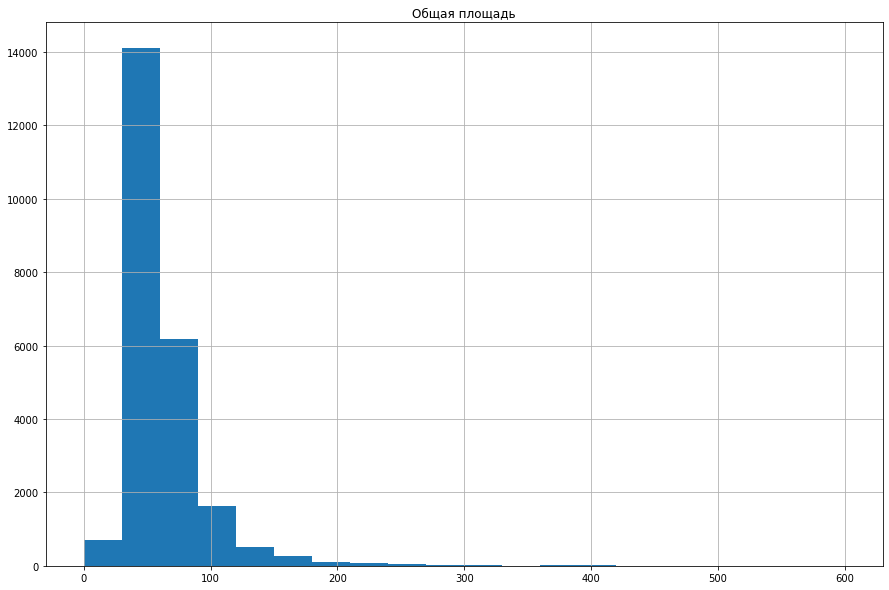

In [ ]:
data['total_area'].hist(bins=20, figsize=(15, 10), range=(0, 600)) # построение гистограммы
plt.title('Общая площадь')
plt.show()

In [ ]:
data['total_area'].describe() # просмотр статистических данных

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [ ]:
data['total_area'].value_counts() # просмотр количества уникальных значений

45.00     419
42.00     383
60.00     347
31.00     346
44.00     345
40.00     315
43.00     301
32.00     289
46.00     282
36.00     280
50.00     279
35.00     262
38.00     237
55.00     227
41.00     227
33.00     224
52.00     218
34.00     218
58.00     217
54.00     217
37.00     213
39.00     210
30.00     206
57.00     201
62.00     193
48.00     190
47.00     188
70.00     183
80.00     175
56.00     173
72.00     170
51.00     168
53.00     167
63.00     163
59.00     153
65.00     147
61.00     140
49.00     134
64.00     132
75.00     130
74.00     124
67.00     115
68.00     112
73.00     104
66.00      93
69.00      84
90.00      83
29.00      81
71.00      79
76.00      77
78.00      77
100.00     72
85.00      69
82.00      66
44.50      61
79.00      60
83.00      59
77.00      59
95.00      59
28.00      56
45.50      54
87.00      49
98.00      48
31.20      47
35.50      46
110.00     45
84.00      45
81.00      45
25.00      45
31.50      44
93.00      44
43.50 

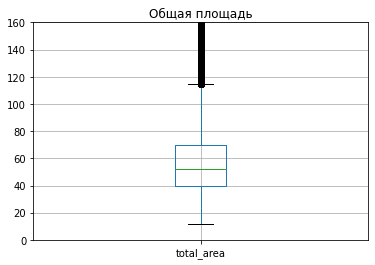

In [ ]:
plt.ylim(0, 160) # при диапазоне (0, 900) плохо видно центральную часть, поэтому принято ограничить ось значением 160

data.boxplot('total_area')

plt.title('Общая площадь')
plt.show()

Диаграмма показывает, что нормальными являются значения от 20 до 115. Удалим значения, выходящие за диапазон 14-160.

In [ ]:
# удаление выбросов в данных
data = data[(data['total_area'] < 160) & (data['total_area'] > 14)] # в соответствии со сводом правил СП 54.13330.2016 жилая площадь д.б. не менее 14 м.кв., значит общая площадь д.б. ещё больше

In [ ]:
data['total_area'].describe() # проверка количества отсавшихся значений и изменения статистических данных

count    23225.000000
mean        56.969109
std         23.750463
min         15.000000
25%         40.000000
50%         51.200000
75%         68.000000
max        159.900000
Name: total_area, dtype: float64

**Параметр: жилая площадь. Вывод гистограммы, обработка аномальных значений.**

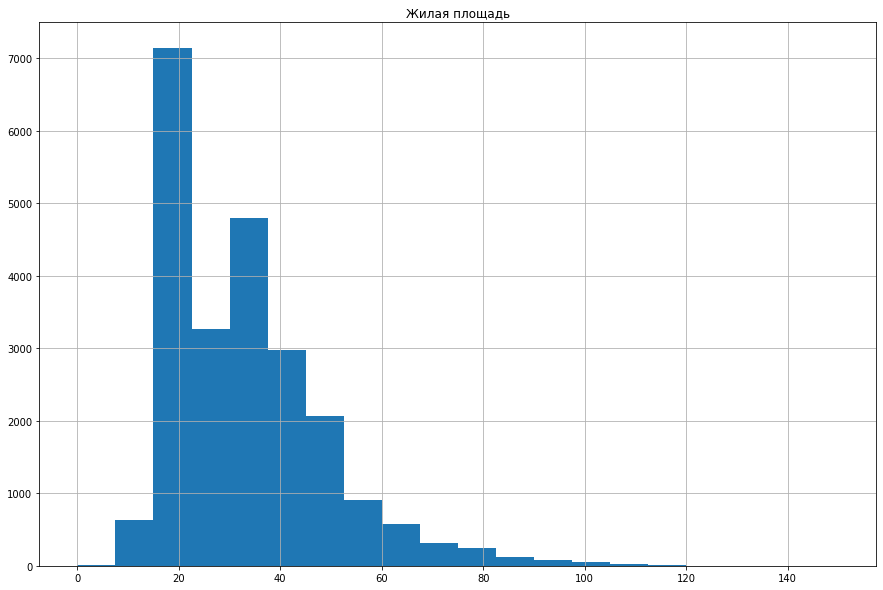

In [ ]:
data['living_area'].hist(bins=20, figsize=(15, 10), range=(0, 150)) # построение гистограммы
plt.title('Жилая площадь')
plt.show()

In [ ]:
data['living_area'].describe() # просмотр статистических данных

count    23225.000000
mean        32.588159
std         15.740921
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        128.000000
Name: living_area, dtype: float64

In [ ]:
data['living_area'].value_counts() # просмотр количества уникальных значений

18.0     1877
17.0     1276
30.0     1208
16.0     1098
28.0      932
20.0      875
19.0      786
31.0      785
32.0      702
27.0      675
15.0      656
29.0      630
40.0      496
42.0      494
43.0      492
34.0      478
33.0      469
44.0      429
35.0      403
36.0      402
38.0      379
39.0      369
26.0      359
14.0      357
37.0      349
48.0      324
45.0      320
41.0      315
46.0      296
47.0      292
21.0      291
22.0      283
50.0      266
25.0      251
24.0      239
49.0      234
52.0      194
23.0      185
53.0      173
54.0      172
56.0      162
51.0      142
55.0      138
60.0      126
57.0      106
58.0       99
64.0       89
13.0       86
63.0       74
12.0       73
62.0       70
68.0       69
70.0       68
61.0       60
59.0       57
66.0       57
65.0       56
11.0       54
67.0       51
10.0       46
72.0       43
75.0       42
76.0       38
80.0       37
69.0       36
73.0       35
71.0       34
74.0       29
79.0       28
78.0       27
77.0       27
84.0  

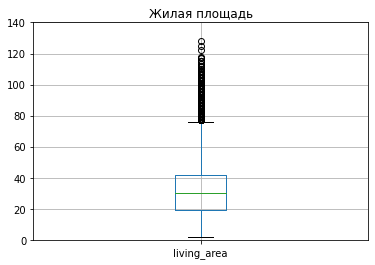

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 140)
data.boxplot('living_area')

plt.title('Жилая площадь')
plt.show()

Диаграмма показывает, что нормальными являются значения от 5 до 75. Удалим значения, выходящие за диапазон 14-130.

In [ ]:
# удаление выбросов
data = data[(data['living_area'] < 130) & (data['living_area'] > 14)] # в соответствии со сводом правил СП 54.13330.2016 жилая площадь д.б. не менее 14 м.кв.

In [ ]:
data['living_area'].describe() # проверка количества отсавшихся значений и изменения статистических данных

count    22583.000000
mean        33.149936
std         15.598494
min         15.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        128.000000
Name: living_area, dtype: float64

**Параметр: площадь кухни. Вывод гистограммы, обработка аномальных значений.**

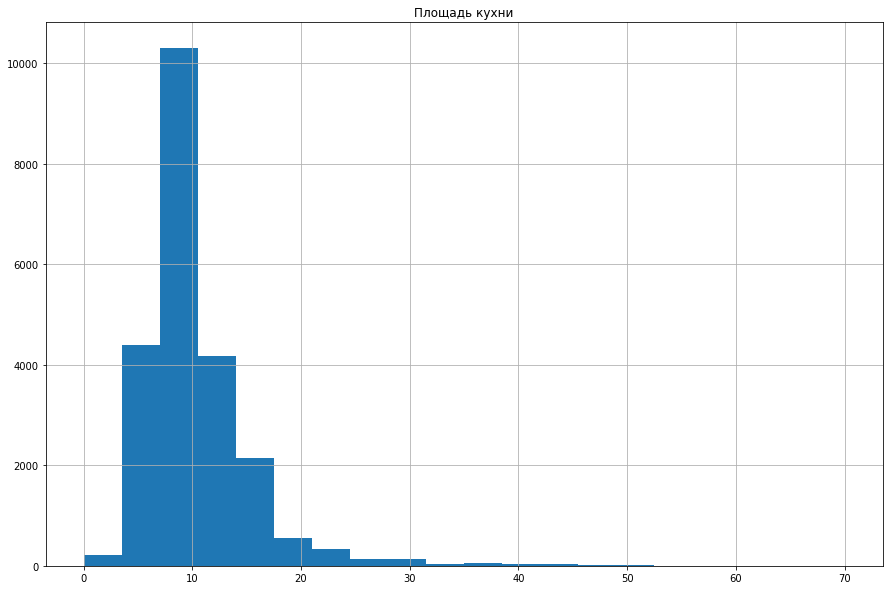

In [ ]:
data['kitchen_area'].hist(bins=20, figsize=(15, 10), range=(0, 70)) # построение гистограммы

plt.title('Площадь кухни')
plt.show()

In [ ]:
data['kitchen_area'].describe() # просмотр статистических данных

count    22583.000000
mean        10.098703
std          5.061140
min          0.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         93.000000
Name: kitchen_area, dtype: float64

In [ ]:
data['kitchen_area'].value_counts() # просмотр количества уникальных значений

6.0     3272
8.0     3177
10.0    2721
9.0     2220
7.0     2187
11.0    1877
12.0    1484
5.0      984
14.0     862
13.0     814
15.0     626
16.0     411
17.0     249
18.0     227
20.0     174
19.0     148
4.0      144
3.0      120
22.0     107
21.0      84
25.0      79
23.0      69
24.0      68
2.0       65
30.0      52
28.0      48
26.0      37
35.0      24
27.0      23
29.0      22
40.0      21
1.0       20
36.0      19
31.0      15
32.0      14
38.0      13
33.0      11
34.0      10
45.0      10
43.0      10
41.0       7
39.0       6
50.0       6
42.0       6
37.0       4
44.0       4
0.0        3
48.0       3
56.0       3
46.0       3
53.0       2
58.0       2
47.0       2
51.0       2
64.0       2
49.0       2
93.0       1
60.0       1
52.0       1
72.0       1
62.0       1
63.0       1
65.0       1
75.0       1
Name: kitchen_area, dtype: int64

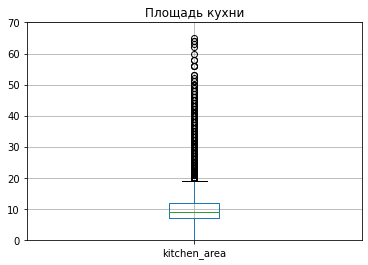

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 70)
data.boxplot('kitchen_area')

plt.title('Площадь кухни')
plt.show()

Диаграмма показывает, что нормальными являются значения от 2 до 18. Удалим значения, выходящие за диапазон 5-50.

In [ ]:
# удаление выбросов
data = data[(data['kitchen_area'] < 50) & (data['kitchen_area'] > 5)]  # в соответствии со сводом правил СП 54.13330.2016 площадь кухни д.б. не менее 8 м.кв., подойдем более консервативно и возьмем не менее 5 м.кв.

In [ ]:
data['kitchen_area'].describe() # проверка количества отсавшихся значений и изменения статистических данных

count    21222.000000
mean        10.394449
std          4.718188
min          6.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         49.000000
Name: kitchen_area, dtype: float64

**Параметр: цена объекта. Вывод гистограммы, обработка аномальных значений.**

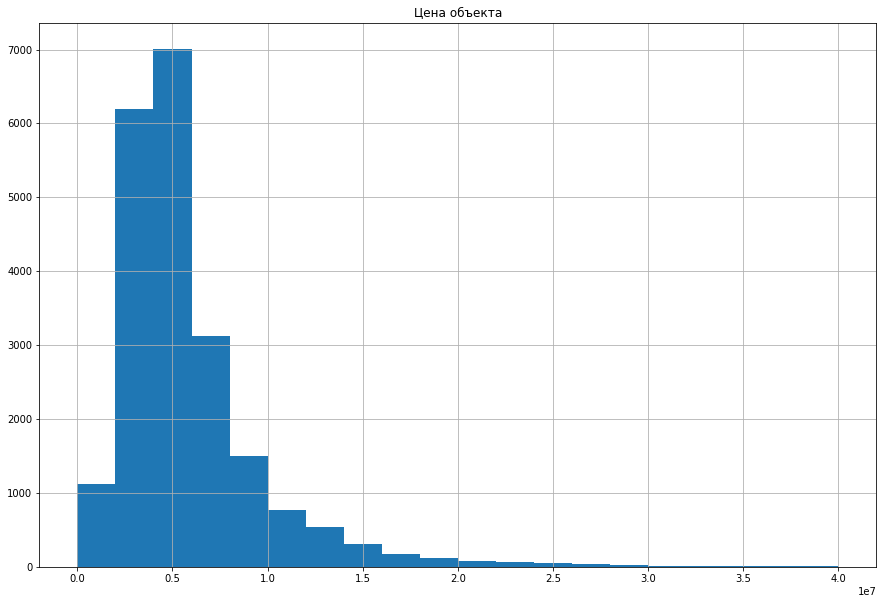

In [ ]:
data['last_price'].hist(bins=20, figsize=(15, 10), range=(0, 40000000)) # построение гистограммы

plt.title('Цена объекта')
plt.show()

In [ ]:
data['last_price'].describe()  # просмотр статистических данных

count    2.122200e+04
mean     5.963657e+06
std      4.752551e+06
min      1.219000e+04
25%      3.550000e+06
50%      4.785000e+06
75%      6.800000e+06
max      1.240000e+08
Name: last_price, dtype: float64

In [ ]:
data['last_price'].value_counts() # просмотр количества уникальных значений

4500000.0      324
3500000.0      249
4200000.0      240
4300000.0      239
4000000.0      234
3600000.0      220
5500000.0      217
4100000.0      213
3800000.0      213
3900000.0      205
3300000.0      205
4600000.0      201
3700000.0      197
3200000.0      197
5200000.0      197
5000000.0      194
3400000.0      193
4800000.0      187
5100000.0      185
5300000.0      183
4700000.0      182
3100000.0      180
4900000.0      179
6500000.0      174
4400000.0      165
3000000.0      154
3950000.0      148
7500000.0      144
6000000.0      144
3650000.0      143
5600000.0      142
4150000.0      139
5800000.0      136
5400000.0      131
2900000.0      130
3750000.0      128
6200000.0      127
8500000.0      125
6300000.0      124
4950000.0      123
2800000.0      119
4650000.0      117
5900000.0      116
4250000.0      114
7000000.0      114
5700000.0      114
3550000.0      113
2700000.0      113
3850000.0      112
4350000.0      111
6800000.0      109
3150000.0      108
2950000.0   

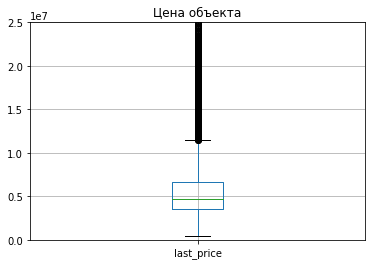

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 25000000)
data.boxplot('last_price')

plt.title('Цена объекта')
plt.show()

Диаграмма показывает, что нормальными являются значения от 500000 до 12 000 000. Удалим значения, выходящие за диапазон 400000-35000000.

In [ ]:
# удаление выбросов
data = data[(data['last_price'] < 35000000) & (data['last_price'] > 400000)]  #

In [ ]:
data['last_price'].describe() # проверка количества отсавшихся значений и изменения статистических данных

count    2.114000e+04
mean     5.803355e+06
std      3.865506e+06
min      4.300000e+05
25%      3.550000e+06
50%      4.750000e+06
75%      6.800000e+06
max      3.487856e+07
Name: last_price, dtype: float64

**Параметр: количество комнат. Вывод гистограммы, обработка аномальных значений.**

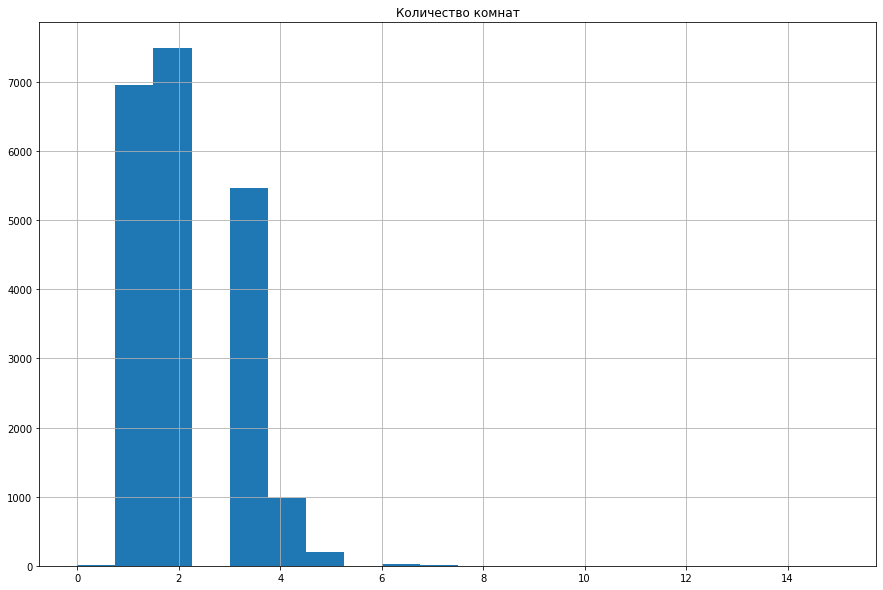

In [ ]:
data['rooms'].hist(bins=20, figsize=(15, 10), range=(0, 15))  # построение гистограммы

plt.title('Количество комнат')
plt.show()

In [ ]:
data['rooms'].describe()  # просмотр статистических данных

count    21140.000000
mean         2.057852
std          0.944865
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

In [ ]:
data['rooms'].value_counts() # просмотр количества уникальных значений

2    7492
1    6951
3    5464
4     984
5     194
6      32
0      12
7      10
8       1
Name: rooms, dtype: int64

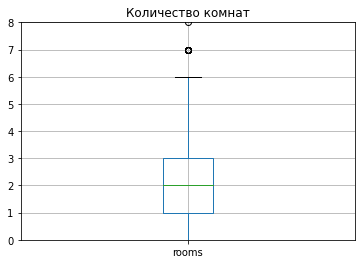

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 8)
data.boxplot('rooms')

plt.title('Количество комнат')
plt.show()

Данный столбец оставляем без изменений, т.к. в нем незначительное количество выбросов.

**Параметр: высота потолков. Вывод гистограммы, обработка аномальных значений.**

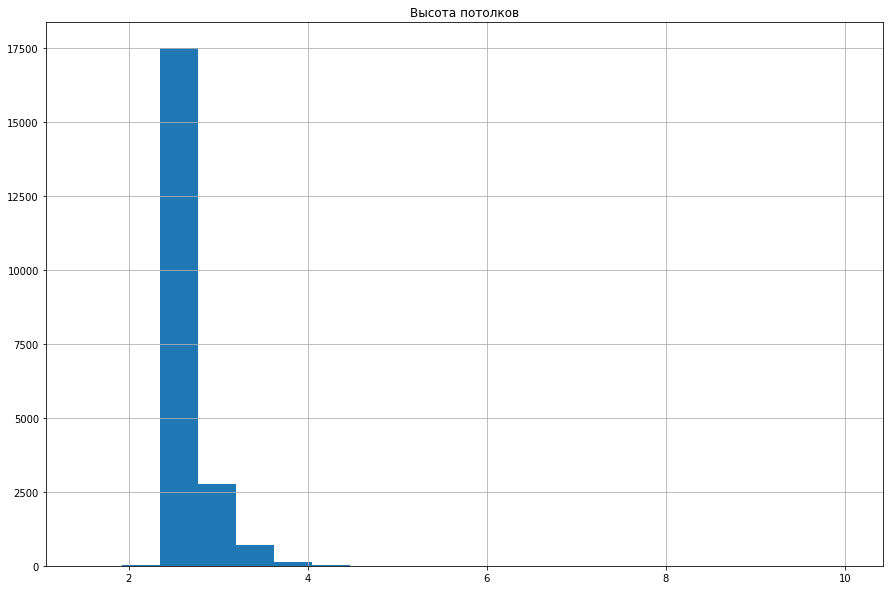

In [ ]:
data['ceiling_height'].hist(bins=20, figsize=(15, 10), range=(1.5, 10))  # построение гистограммы

plt.title('Высота потолков')
plt.show()

In [ ]:
data['ceiling_height'].describe() # просмотр статистических данных

count    21140.000000
mean         2.716082
std          0.763772
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64

In [ ]:
data['ceiling_height'].value_counts() # просмотр количества уникальных значений

2.65     8722
2.50     3104
2.60     1546
2.70     1442
3.00     1000
2.80      918
2.55      895
2.75      827
3.20      240
3.10      182
2.90      144
2.56      132
3.30      109
3.50       98
2.57       93
2.85       92
2.64       79
2.54       71
3.40       71
2.52       65
2.53       64
2.76       56
2.58       56
2.77       56
3.15       52
2.78       50
3.05       42
2.95       41
2.67       36
3.25       35
2.73       33
2.72       30
2.51       29
4.00       27
2.74       26
3.70       24
3.60       24
2.68       22
2.40       19
2.84       18
3.80       18
2.66       17
2.82       17
3.12       15
3.55       14
2.71       13
2.83       13
2.45       13
2.88       12
2.59       12
3.35       12
2.63       12
2.62       12
3.08       12
3.06       11
3.07       11
2.00       11
3.18       10
2.79       10
3.13       10
3.45        9
2.92        9
4.20        9
2.87        9
3.90        8
2.81        8
27.00       7
3.95        7
3.75        7
3.02        7
2.48        7
3.04  

In [ ]:
# замена значений с явными ошибками на правильные
data.loc[data['ceiling_height'] == 20, 'ceiling_height'] = 2.0
data.loc[data['ceiling_height'] == 22.6, 'ceiling_height'] = 2.26
data.loc[data['ceiling_height'] == 24, 'ceiling_height'] = 2.4
data.loc[data['ceiling_height'] == 25, 'ceiling_height'] = 2.5
data.loc[data['ceiling_height'] == 26, 'ceiling_height'] = 2.6
data.loc[data['ceiling_height'] == 27, 'ceiling_height'] = 2.7
data.loc[data['ceiling_height'] == 27.5, 'ceiling_height'] = 2.75
data.loc[data['ceiling_height'] == 32, 'ceiling_height'] = 3.2

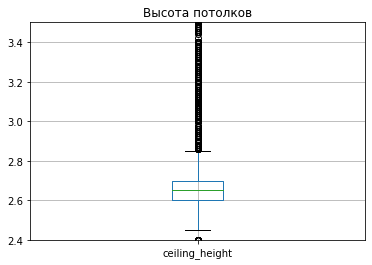

In [ ]:
# построение диаграммы Размаха
plt.ylim(2.4, 3.5) # при диапазоне (1, 6) плохо видно центральную часть, поэтому принято ограничить ось значением диапазоном 2.4-3
data.boxplot('ceiling_height')

plt.title('Высота потолков')
plt.show()

Диаграмма показывает, что нормальными являются значения от 2.45 до 2.85. Удалим значения, выходящие за диапазон 2.4-3.5.

In [ ]:
# удаление выбросов
data = data[(data['ceiling_height'] < 3.5) & (data['ceiling_height'] > 2.4)]  # высота потолков менее 2.4 метров маловероятна

In [ ]:
data['ceiling_height'].describe() # проверка количества отсавшихся значений и изменения статистических данных

count    20802.000000
mean         2.678342
std          0.162412
min          2.450000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.490000
Name: ceiling_height, dtype: float64

**Параметр: тип этажа квартиры («первый», «последний», «другой»). Вывод гистограммы, обработка аномальных значений.**

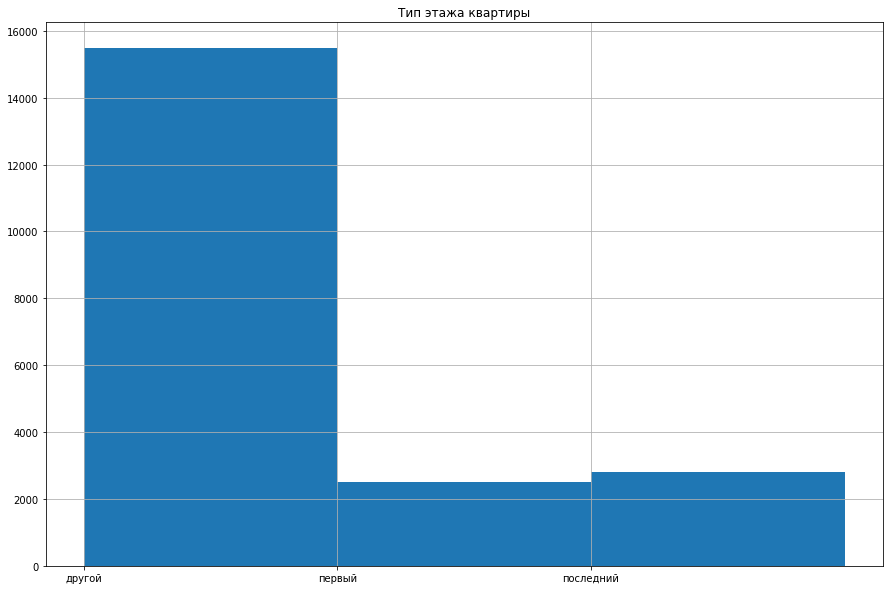

In [ ]:
data['flat_floor_type'].hist(bins=3, figsize=(15, 10), range=(0, 3)) # построение гистограммы

plt.title('Тип этажа квартиры')
plt.show()

In [ ]:
data['flat_floor_type'].describe() # просмотр статистических данных

count      20802
unique         3
top       другой
freq       15485
Name: flat_floor_type, dtype: object

In [ ]:
data['flat_floor_type'].value_counts() # просмотр количества уникальных значений

другой       15485
последний     2815
первый        2502
Name: flat_floor_type, dtype: int64

Данный столбец оставляем без изменений, т.к. в нем нет "выбросов" по значениям.

**Параметр: общее количество этажей в доме. Вывод гистограммы, обработка аномальных значений.**

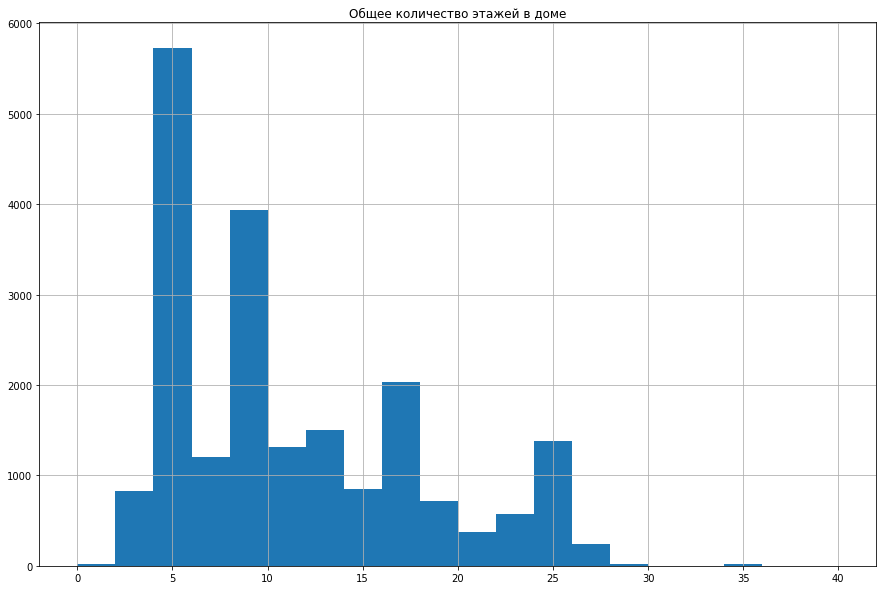

In [ ]:
data['floors_total'].hist(bins=20, figsize=(15, 10), range=(0, 40)) # построение гистограммы

plt.title('Общее количество этажей в доме')
plt.show()

In [ ]:
data['floors_total'].describe() # просмотр статистических данных

count    20737.000000
mean        10.870907
std          6.525914
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [ ]:
data['floors_total'].value_counts() # просмотр количества уникальных значений

5.0     4785
9.0     3619
12.0    1284
16.0    1274
10.0    1124
25.0     975
4.0      942
17.0     758
6.0      705
3.0      526
14.0     509
7.0      499
18.0     436
24.0     411
15.0     340
23.0     316
8.0      315
2.0      301
19.0     278
22.0     256
20.0     239
13.0     213
11.0     188
21.0     136
27.0     131
26.0     108
1.0       23
28.0      21
35.0      20
36.0       3
33.0       1
60.0       1
Name: floors_total, dtype: int64

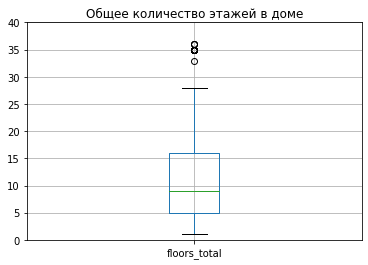

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 40)
data.boxplot('floors_total')

plt.title('Общее количество этажей в доме')
plt.show()

Диаграмма показывает, что нормальными являются значения от 2 до 28. Удалим значения, выходящие за диапазон 0-30.

In [ ]:
# удаление выбросов
data = data[data['floors_total'] < 30]

In [ ]:
data['floors_total'].describe() # проверка количества отсавшихся значений и изменения статистических данных

count    20712.000000
mean        10.840527
std          6.468706
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         28.000000
Name: floors_total, dtype: float64

**Параметр: расстояние до центра города в метрах. Вывод гистограммы, обработка аномальных значений.**

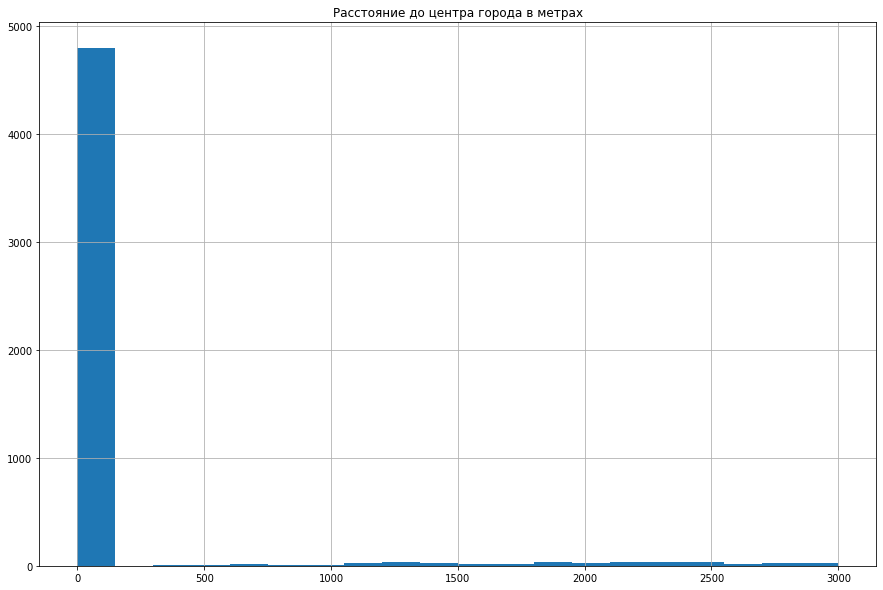

In [ ]:
data['cityCenters_nearest'].hist(bins=20, figsize=(15, 10), range=(0, 3000)) # построение гистограммы

plt.title('Расстояние до центра города в метрах')
plt.show()

In [ ]:
data['cityCenters_nearest'].describe() # просмотр статистических данных

count    20712.000000
mean     11006.981074
std       9447.280383
min          0.000000
25%       2871.250000
50%      11559.500000
75%      15267.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [ ]:
data['cityCenters_nearest'].value_counts().sort_index() # просмотр количества уникальных значений

0        4792
181         1
287         1
318         1
329         1
387         1
399         1
410         1
467         1
472         1
515         1
537         1
552         1
602         2
621         1
623         1
649         1
650         1
653         1
671         1
672         1
675         2
686         2
700         1
730         3
743         2
752         1
769         1
772         2
820         2
830         1
833         1
835         1
867         1
869         1
904         1
911         1
936         1
959         1
996         1
1015        1
1043        1
1053        1
1075        2
1090        1
1096        1
1097        1
1111        1
1113        1
1117        1
1122        1
1124        1
1139        1
1141        1
1146        1
1155        2
1158        1
1162        2
1163        1
1166        1
1178        2
1181        1
1200        1
1205        1
1211        1
1216        1
1217        2
1218        2
1223        1
1226        1
1230        1
1233  

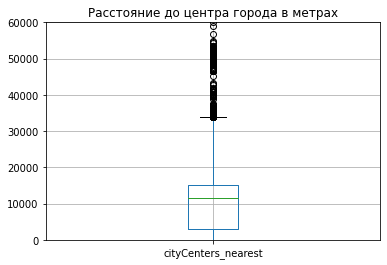

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 60000)
data.boxplot('cityCenters_nearest')

plt.title('Расстояние до центра города в метрах')
plt.show()

В данном столбце довольно много выбросов более 35000, а также много значений 0, которые были проставлены при замене пропусков.

Удаление выбросов в данном столбце выполнять не буду, чтобы не потерять остальные данных, хранящиеся в этих строках.

**Параметр: расстояние до ближайшего парка. Вывод гистограммы, обработка аномальных значений.**

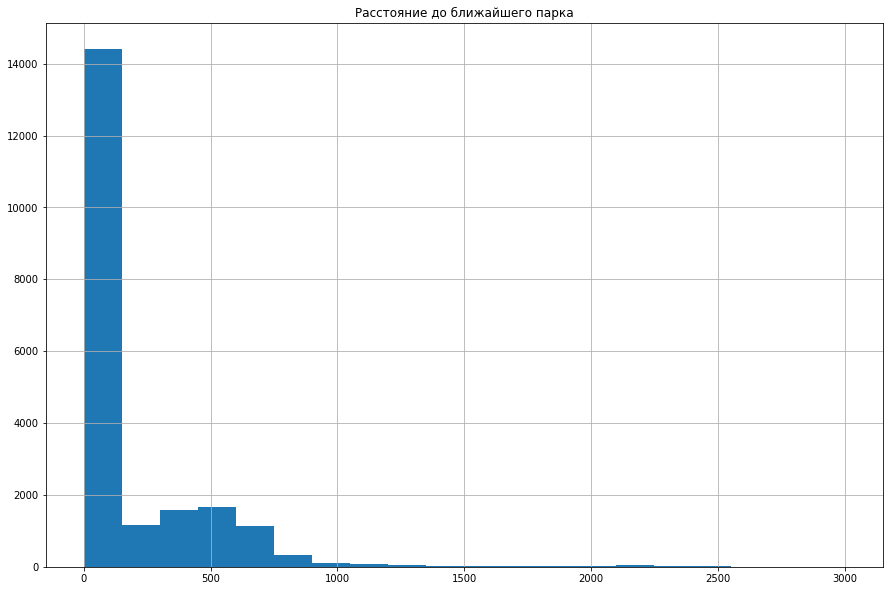

In [ ]:
data['parks_nearest'].hist(bins=20, figsize=(15, 10), range=(0, 3000)) # построение гистограммы

plt.title('Расстояние до ближайшего парка')
plt.show()

In [ ]:
data['parks_nearest'].describe() # просмотр статистических данных

count    20712.000000
mean       165.346659
std        307.269220
min          0.000000
25%          0.000000
50%          0.000000
75%        292.000000
max       3190.000000
Name: parks_nearest, dtype: float64

In [ ]:
data['parks_nearest'].value_counts().sort_index() # просмотр количества уникальных значений

0       13818
1           1
3           1
4           1
7           1
9           2
10          7
11          4
12          1
13          6
14          1
15          5
16          4
17          4
18          7
19          8
20          8
21          4
22          3
23          3
24         12
27          1
28          1
30          3
32          1
33          3
34          3
35          3
36         10
37          6
38         12
39          5
40          6
41         10
42          2
43          4
44          3
45          4
46          5
48          3
49          5
50          4
51         15
52          4
54          3
55          1
56          2
57          9
58          6
59          7
60          2
61          8
63          8
64          3
65          6
66          4
67          1
68          5
69          2
72          2
73          1
74          9
75          4
76          4
77          8
78          5
82          2
83          1
84          2
85          3
86          3
87    

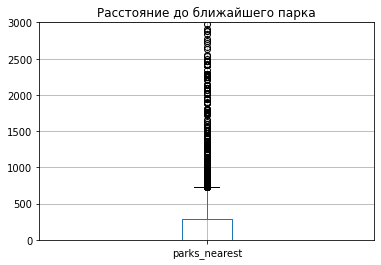

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 3000)
data.boxplot('parks_nearest')

plt.title('Расстояние до ближайшего парка')
plt.show()

В данном столбце довольно много выбросов более 600 м, а также много значений 0, которые были проставлены при замене пропусков.

Удаление выбросов в данном столбце выполнять не буду, чтобы не потерять остальные данных, хранящиеся в этих строках.

#### Скорость продажи квартир

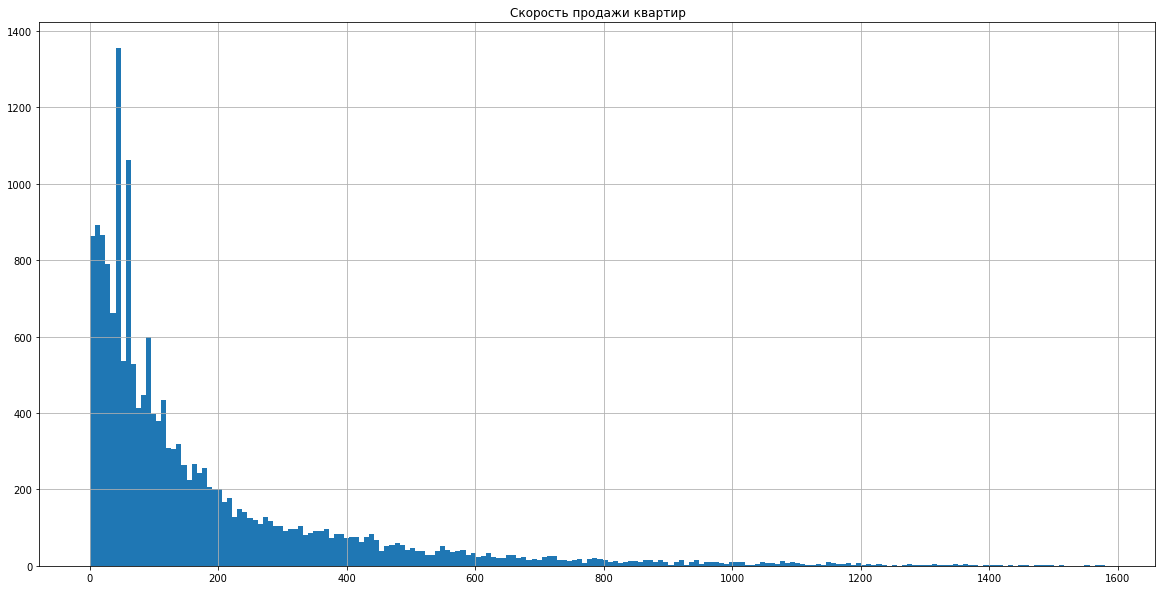

In [ ]:
data['days_exposition'].hist(bins=200, figsize=(20, 10)) # построение гистограммы

plt.title('Скорость продажи квартир')
plt.show()

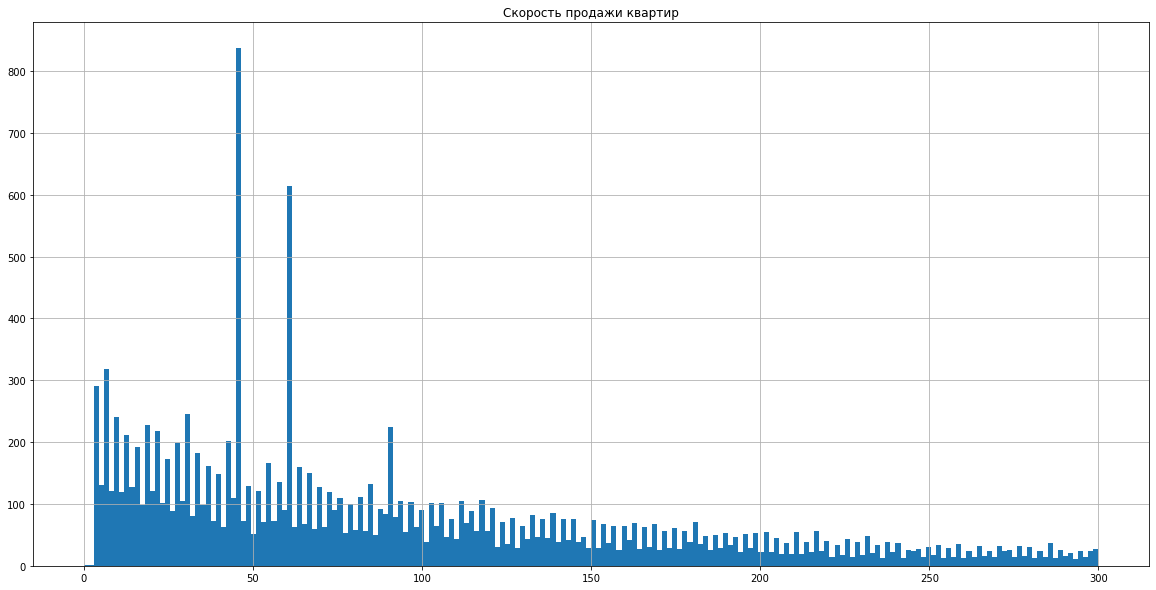

In [ ]:
data['days_exposition'].hist(bins=200, figsize=(20, 10), range=(0, 300)) # построение гистограммы для меньшего диапазона

plt.title('Скорость продажи квартир')
plt.show()

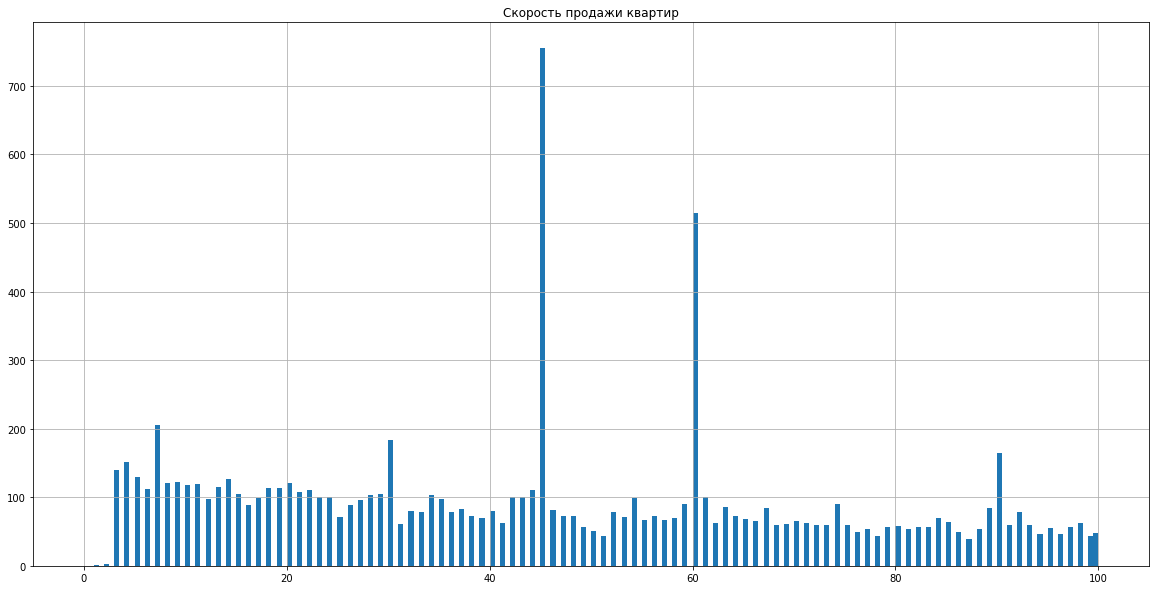

In [ ]:
data['days_exposition'].hist(bins=200, figsize=(20, 10), range=(0, 100)) # построение гистограммы для меньшего диапазона

plt.title('Скорость продажи квартир')
plt.show()

На вышеприведнных графиках есть несколько выбросов. На 7 и 10 день небольшие выбросы, на 45 и 60 день большие.

**Самое большое число продаж приходится на 45 день после публикации объявления.** Возможно данный срок связан с длительностью процедуры оформления покупки квартиры в ипотеку (одобрение ипотеки, согласование конкретной квартиры с банком, оформление документов, регистрация документов в Росреестре).

In [ ]:
# вывод среднего и медианного значения
display(data['days_exposition'].mean()) # расчет среднего значения количества дней продажи квартиры
display(data['days_exposition'].median()) # расчет медианного значения количества дней продажи квартиры

179.94201367654418

95.0

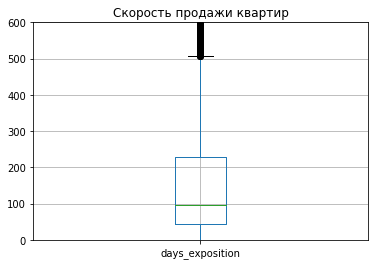

In [ ]:
# построение диаграммы Размаха
plt.ylim(0, 600)
data.boxplot('days_exposition')

plt.title('Скорость продажи квартир')
plt.show()

In [ ]:
data['days_exposition'].describe()

count    17987.000000
mean       179.942014
std        218.517780
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [ ]:
data['days_exposition'].value_counts().sort_index()

1.0         1
2.0         2
3.0       140
4.0       151
5.0       130
6.0       112
7.0       206
8.0       121
9.0       122
10.0      118
11.0      120
12.0       97
13.0      115
14.0      127
15.0      104
16.0       88
17.0       99
18.0      114
19.0      113
20.0      121
21.0      107
22.0      111
23.0      101
24.0      101
25.0       71
26.0       89
27.0       96
28.0      103
29.0      105
30.0      184
31.0       61
32.0       80
33.0       79
34.0      103
35.0       98
36.0       78
37.0       83
38.0       72
39.0       69
40.0       80
41.0       62
42.0      101
43.0      100
44.0      110
45.0      755
46.0       82
47.0       72
48.0       73
49.0       56
50.0       51
51.0       43
52.0       78
53.0       71
54.0       99
55.0       67
56.0       72
57.0       67
58.0       69
59.0       90
60.0      514
61.0      100
62.0       62
63.0       86
64.0       73
65.0       68
66.0       65
67.0       85
68.0       60
69.0       61
70.0       66
71.0       63
72.0  

В исходной таблице было 3181 пропуска по данному параметру, которые вероятнее всего связаны с тем, что квартиры ещё не сняты с продажи, либо это может быть технической ошибкой. Для уточнения нужно обратиться к тем, кто предоставил данные.

Кроме того, как показывает диаграмма Размаха, значения более 520 дней можно считать выбросами. Если их удалить, то результаты могут поменяться, но в задании не требуется удалять выбросы по этому столбцу, поэтому оставляем их без изменений.

**Имеющиеся данные позволяют сделать следующие выводы:**

Среднее время продажи квартир: 180 дня.

Медианное время продажи квартир: 95 дней.

Нормальное время продажи квартир составляет от 50 до 250 дней.

Продажи менее 50 дней можно считать быстрыми, более 250 дней - долгими.

#### Зависимость цены квартиры от различных параметров

**Зависимость полной стоимости квартиры от общей площади**

In [ ]:
data.pivot_table(index='last_price', values='total_area') # построение сводной таблицы

,total_area
last_price,
430000.0,42.200000
440000.0,40.000000
450000.0,40.100000
470000.0,40.833333
480000.0,32.000000
490000.0,34.550000
500000.0,38.675000
520000.0,30.000000
530000.0,29.600000


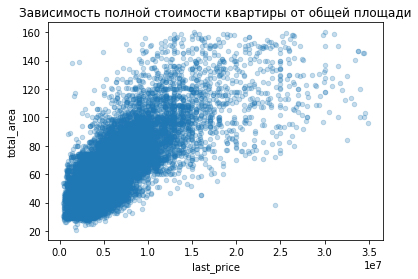

In [ ]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.25) # построение графика зависимости

plt.title('Зависимость полной стоимости квартиры от общей площади')
plt.show()

In [ ]:
data['last_price'].corr(data['total_area']) # расчет коэффициента корреляции

0.7595998915490796

**Зависимость полной стоимости квартиры от жилой площади**

In [ ]:
data.pivot_table(index='last_price', values='living_area')  # построение сводной таблицы

,living_area
last_price,
430000.0,23.500000
440000.0,23.000000
450000.0,23.000000
470000.0,27.000000
480000.0,16.000000
490000.0,20.000000
500000.0,21.250000
520000.0,18.000000
530000.0,16.000000


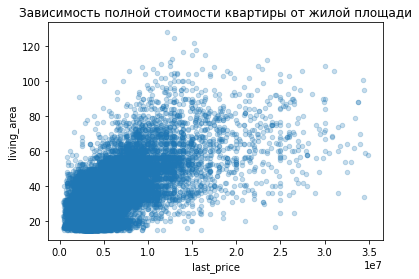

In [ ]:
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.25) # построение графика зависимости

plt.title('Зависимость полной стоимости квартиры от жилой площади')
plt.show()

In [ ]:
data['last_price'].corr(data['living_area']) # расчет коэффициента корреляции

0.6439471109276503

**Зависимость полной стоимости квартиры от площади кухни**

In [ ]:
data.pivot_table(index='last_price', values='kitchen_area')  # построение сводной таблицы

,kitchen_area
last_price,
430000.0,7.500000
440000.0,7.000000
450000.0,6.750000
470000.0,8.000000
480000.0,7.000000
490000.0,6.500000
500000.0,7.500000
520000.0,6.000000
530000.0,6.000000


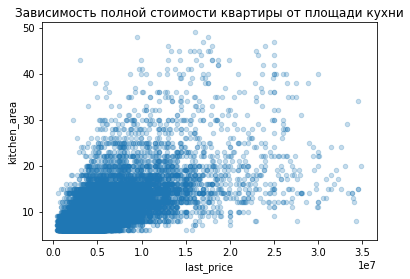

In [ ]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.25) # построение графика зависимости

plt.title('Зависимость полной стоимости квартиры от площади кухни')
plt.show()

In [ ]:
data['last_price'].corr(data['kitchen_area']) # расчет коэффициента корреляции

0.5939768897213678

**Зависимость полной стоимости квартиры от количества комнат**

In [ ]:
data.pivot_table(index='last_price', values='rooms')  # построение сводной таблицы

,rooms
last_price,
430000.0,1.500000
440000.0,1.000000
450000.0,1.750000
470000.0,1.333333
480000.0,1.000000
490000.0,1.000000
500000.0,1.250000
520000.0,1.000000
530000.0,1.000000


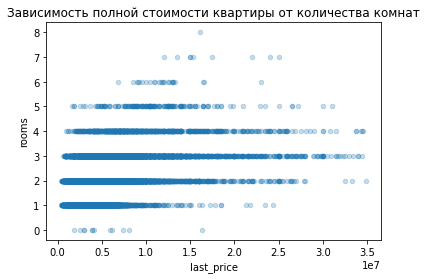

In [ ]:
data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.25) # построение графика зависимости

plt.title('Зависимость полной стоимости квартиры от количества комнат')
plt.show()

In [ ]:
data['last_price'].corr(data['rooms']) # расчет коэффициента корреляции

0.4595248777434605

**Зависимость полной стоимости квартиры от типа этажа**

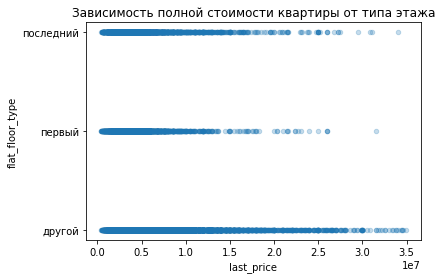

In [ ]:
data.plot(x='last_price', y='flat_floor_type', kind='scatter', alpha=0.25) # построение графика зависимости

plt.title('Зависимость полной стоимости квартиры от типа этажа')
plt.show()

**Зависимость полной стоимости квартиры от дня недели, месяца и года**

In [ ]:
data.pivot_table(index='last_price', values=['weekday', 'month', 'year'])  # построение сводной таблицы

,month,weekday,year
last_price,,,
430000.0,5.000000,0.500000,2018.500000
440000.0,7.000000,1.000000,2018.000000
450000.0,6.000000,2.250000,2017.750000
470000.0,3.666667,4.000000,2018.000000
480000.0,1.000000,6.000000,2019.000000
490000.0,8.500000,1.500000,2016.500000
500000.0,4.000000,2.000000,2017.750000
520000.0,9.000000,4.000000,2017.000000
530000.0,2.000000,2.000000,2019.000000


<function matplotlib.pyplot.show(close=None, block=None)>

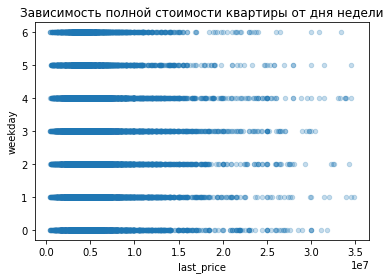

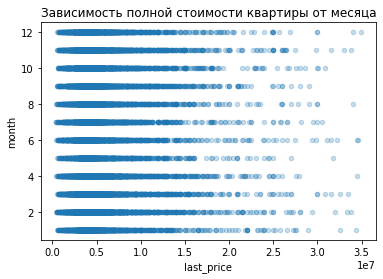

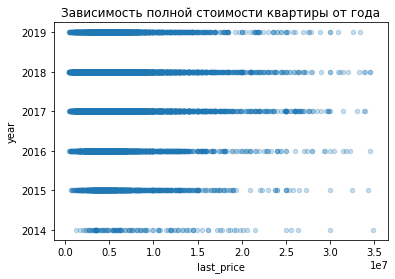

In [ ]:
# построение графика зависимости
data.plot(x='last_price', y='weekday', kind='scatter', alpha=0.25)
plt.title('Зависимость полной стоимости квартиры от дня недели')
plt.show

data.plot(x='last_price', y='month', kind='scatter', alpha=0.25)
plt.title('Зависимость полной стоимости квартиры от месяца')
plt.show

data.plot(x='last_price', y='year', kind='scatter', alpha=0.25)
plt.title('Зависимость полной стоимости квартиры от года')
plt.show

**Больше всего на полную стоимость квартиры влияет:**

1. общая площадь квартиры - коэффициент корреляции равен 0.760
2. жилая площадь квартиры - коэффициент корреляции равен 0.644 (данный параметр зависит от общей площади квартиры)
3. площадь кухни - коэффициент корреляции равен 0.594 (влияние небольшое)
4. количество комнат - коэффициент корреляции равен 0.460 (влияние незначительное)

Тип этажа незначительно влияет на стоимость квартиры, но по диаграмме видно, что более дорогие квартиры имеют тип этажа "другой".

День и месяц подачи объявления не влияет на стоимость квартиры.

График с зависимостью стоимости квартиры от года подачи объявления показывает, что с 2014 по 2017 годы количество дорогих квартир увеличивалось, затем с 2017 по 2019 годы количество дорогих квартир начало незначительно уменьшаться.

#### Расчет средней цены одного квадратного метра в 10 населенных пунктах

In [ ]:
# создание таблицы с 10 населенными пунтками с самым большим количеством объявлений и средней ценой одного кв.метра

top_10 = data.pivot_table(index='replace_locality_name', values='one_meter_price', aggfunc=('count', 'mean')).sort_values(by='count', ascending=False)
top_10 = top_10[:10] # сохранение первых десяти населенных пунктов с самым большим количеством объявлений
top_10 = top_10.sort_values(by='mean', ascending=False) # сортировка по цене за метр
top_10

,count,mean
replace_locality_name,,
Санкт-Петербург,13844,110250.204926
Пушкин,293,104191.675768
Кудрово,401,94185.561097
Парголово,273,88398.945055
Мурино,468,84377.455128
Шушары,392,77088.413265
Колпино,311,75370.488746
Гатчина,261,69191.877395
Всеволожск,362,69017.555249


In [ ]:
# выделение населенного пункта с максимальной и минимальной стоимостью одного квадратного метра
display(top_10.head(1), top_10.tail(1))

,count,mean
replace_locality_name,,
Санкт-Петербург,13844,110250.204926


,count,mean
replace_locality_name,,
Выборг,198,57444.757576


#### Расчет средней цены одного квадратного метра в зависимости от удаленности от центра

In [ ]:
# Создание сводной таблицы с зависимостью цены одного кв.метра от отдаленности от центра Санкт-Петербурга
spb_data = data[data['locality_name'] == 'Санкт-Петербург']
km_one_meter_price = spb_data.pivot_table(index='cityCenters_nearest_km', values='one_meter_price', aggfunc=('mean')).sort_values(by='cityCenters_nearest_km')
km_one_meter_price

,one_meter_price
cityCenters_nearest_km,
0.0,132239.000000
1.0,131388.726562
2.0,127231.766497
3.0,115626.025641
4.0,125203.014625
5.0,133858.228532
6.0,133946.783158
7.0,134372.632184
8.0,123246.128060


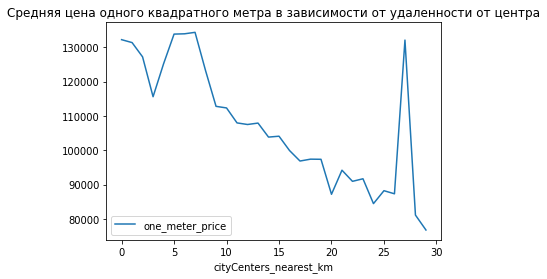

In [ ]:
km_one_meter_price.plot() # построение графика с зависимостью цены одного кв.метра от отдаленности от центра Санкт-Петербурга

plt.title('Средняя цена одного квадратного метра в зависимости от удаленности от центра')
plt.show()

Вышеприведенный график показывает обратную зависимость цены одного квадратного метра квартиры от отденности от центра Санкт-Петербурга. **Чем дальше от центра, тем ниже цена**. Также на графике есть отклонения от общей тенденции, но они могут быть вызваны другими параметрами.

### Напишите общий вывод

#### Выполнено исследование объявлений о продаже квартир в Санкт-Петербурге и соседних населенных пунктах по данным сервиса Яндекс Недвижимость.
#### В процессе исследования были выполнены следующие шаги:
1. **Изучена общая информация о датафрейме и построены гистограммы по всем параметрам.**

Были выявлены пропуски и неправильный тип данных в нескольких столбцах.

2. **Выполнена предобработка данных.**

Были найдены и заполнены пропущенные значения там, где это возможно. Затем выполнено изменение типа данных. Далее был выполнен поиск явных и неявных дубликатов. Явных дубликатов найдено не было, а неявные дубликаты были устранены.

3. **Добавлены в таблицу новые столбцы:**
* цена одного квадратного метра
* день недели публикации объявления
* месяц публикации объявления
* год публикации объявления
* тип этажа квартиры
* расстояние до центра города в километрах

4. **Проведен исследовательский анализ данных.**

**Изучены следующие параметры:**
* общая площадь
* жилая площадь
* площадь кухни
* цена объекта
* количество комнат
* высота потолков
* тип этажа квартиры («первый», «последний», «другой»)
* общее количество этажей в доме
* расстояние до центра города в метрах
* расстояние до ближайшего парка

По результатам удалены или устранены аномальные значения (выбросы).

**Изучена скорость продажи квартир:**
* Среднее время продажи квартир: 180 дня.
* Медианное время продажи квартир: 95 дней.

**Определены факторы, которые больше всего влияют на общую (полную) стоимость объекта:**

*Больше всего на полную стоимость квартиры влияет:*

* общая площадь квартиры - коэффициент корреляции равен 0.760

* жилая площадь квартиры - коэффициент корреляции равен 0.644 (данный параметр зависит от общей площади квартиры)

* площадь кухни - коэффициент корреляции равен 0.594 (влияние небольшое)

* количество комнат - коэффициент корреляции равен 0.460 (влияние незначительное)

Тип этажа незначительно влияет на стоимость квартиры, но по диаграмме видно, что более дорогие квартиры имеют тип этажа "другой".

День, месяц и год подачи объявления не влияет на стоимость квартиры.

**Рассчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений:**
* Максимальная средняя цена - Санкт-Петербург - 110250 руб./кв.м
* Максимальная средняя цена - Выборг - 57445 руб./кв.м

**Рассчитана средняя цена одного квадратного метра в зависимости от удаленности от центра:**

График показывает обратную зависимость цены одного квадратного метра квартиры от отденности от центра Санкт-Петербурга.

*Чем дальше от центра, тем ниже цена*.

Также на графике есть отклонения от общей тенденции, но они могут быть вызваны другими параметрами.
